# Предложение 3

Стимулировать короткие поездки в "богатых" зонах.

In [29]:
import clickhouse_connect
import json
from dotenv import load_dotenv
import os
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

In [7]:
# Load config from file
with open('./dags/conf/config.json', 'r') as f:
    CONFIG = json.load(f)

# Load credentials
load_dotenv('./dags/conf/.env', override=True)

# TODO
CONFIG['clickhouse']['host'] = 'localhost'

db = CONFIG['clickhouse']['dbs']['golden_db']


In [61]:
def analyze_trip_distance_distribution(df):
    """
    Analyze the distribution of trip distances and identify natural breakpoints
    """
    
    # Basic statistics
    pd.set_option('display.float_format', '{:.2f}'.format)
    print("\nTrip Distance Statistics:")
    print(df['trip_distance'].describe())
    
    # Percentiles
    percentiles = [10, 25, 50, 75, 90, 95, 99]
    print("\nDistance Percentiles:")
    for p in percentiles:
        value = df['trip_distance'].quantile(p/100)
        print(f"  {p}th percentile: {value:.2f} miles")
    
    # Find trip segments boundaries using K-Means
    print("\nFinding trip segment boundaries using K-Means")
    
    # Reshape trip distances for KMeans
    distances = df['trip_distance'].values.reshape(-1, 1)
    
    # Use 4 segments - Short, Normal, Long, Extra Long
    kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
    df['distance_cluster'] = kmeans.fit_predict(distances)
    
    # Get cluster centers and sort them
    centers = kmeans.cluster_centers_.flatten()
    cluster_labels = np.argsort(centers)
    label_mapping = {cluster_labels[0]: 'Short', 
                     cluster_labels[1]: 'Normal',
                     cluster_labels[2]: 'Long',
                     cluster_labels[3]: 'Extra long'}
    df['trip_category'] = df['distance_cluster'].map(label_mapping)
    
    # Calculate boundaries
    short_max = df[df['trip_category'] == 'Short']['trip_distance'].max()
    normal_max = df[df['trip_category'] == 'Normal']['trip_distance'].max()
    long_max = df[df['trip_category'] == 'Long']['trip_distance'].max()
    
    print(f"\nIdentified Trip Categories:")
    print(f"  Short trips:  0 - {short_max:.2f} miles")
    print(f"  Normal trips:  {short_max:.2f} - {normal_max:.2f} miles")
    print(f"  Long trips:  {normal_max:.2f} - {long_max:.2f} miles")
    print(f"  Extra long trips:   {long_max:.2f}+ miles")
    
    # Compare distributions
    dist = df['trip_category'].value_counts(normalize=True).sort_index()
    print(f"\nTrip Category Distribution")
    print(dist)
    
    return df, short_max, dist

In [ ]:
def estimate_short_trip_elasticity(df, zone_stats):
    """
    Estimate price elasticity specifically for short trips
    """
    print("\n" + "="*80)
    print("STEP 5: SHORT TRIP PRICE ELASTICITY")
    print("="*80)
    
    # Focus on short trips
    short_trips = df[df['trip_category'] == 'Short'].copy()
    
    # Merge zone characteristics
    short_trips = short_trips.merge(
        zone_stats[['zone_id', 'zone_type']], 
        left_on='PULocationID', 
        right_on='zone_id',
        how='left'
    )
    
    # Aggregate by zone-hour for short trips
    short_zone_hour = short_trips.groupby(['PULocationID', 'hour']).agg({
        'fare_amount': ['count', 'mean'],
        'fare_per_mile': 'mean',
        'trip_distance': 'mean'
    }).reset_index()
    
    short_zone_hour.columns = ['zone_id', 'hour', 'trip_count', 'avg_fare', 
                                'avg_fare_per_mile', 'avg_distance']
    
    # Filter for meaningful data
    short_zone_hour = short_zone_hour[
        (short_zone_hour['trip_count'] >= 3) &
        (short_zone_hour['avg_fare'] > 0)
    ].copy()
    
    print(f"\nAnalyzing {len(short_zone_hour):,} zone-hour combinations for short trips")
    
    # Log transformation
    short_zone_hour['log_quantity'] = np.log(short_zone_hour['trip_count'])
    short_zone_hour['log_price'] = np.log(short_zone_hour['avg_fare'])
    
    # Regression with hour fixed effects
    X = short_zone_hour[['log_price', 'hour']].copy()
    X = pd.get_dummies(X, columns=['hour'], drop_first=True)
    y = short_zone_hour['log_quantity']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    elasticity_short = model.coef_[0]
    r2_short = model.score(X_test, y_test)
    
    print(f"\nShort Trip Elasticity:")
    print(f"  Elasticity: {elasticity_short:.3f}")
    print(f"  R²: {r2_short:.3f}")
    print(f"  Interpretation: 10% price decrease → {-elasticity_short*10:.1f}% increase in short trips")
    
    # Compare to overall elasticity
    print(f"\n[Comparison to All Trips]")
    
    all_zone_hour = df.groupby(['PULocationID', 'hour']).agg({
        'fare_amount': ['count', 'mean']
    }).reset_index()
    all_zone_hour.columns = ['zone_id', 'hour', 'trip_count', 'avg_fare']
    all_zone_hour = all_zone_hour[all_zone_hour['trip_count'] >= 3].copy()
    
    all_zone_hour['log_quantity'] = np.log(all_zone_hour['trip_count'])
    all_zone_hour['log_price'] = np.log(all_zone_hour['avg_fare'])
    
    X_all = all_zone_hour[['log_price', 'hour']].copy()
    X_all = pd.get_dummies(X_all, columns=['hour'], drop_first=True)
    y_all = all_zone_hour['log_quantity']
    
    model_all = LinearRegression()
    model_all.fit(X_all, y_all)
    elasticity_all = model_all.coef_[0]
    
    print(f"  All trips elasticity: {elasticity_all:.3f}")
    print(f"  Short trips elasticity: {elasticity_short:.3f}")
    
    if abs(elasticity_short) > abs(elasticity_all):
        print(f"  → Short trips are MORE price-sensitive (|{elasticity_short:.3f}| > |{elasticity_all:.3f}|)")
        print(f"    This means discounts will be MORE effective for short trips!")
    else:
        print(f"  → Short trips are LESS price-sensitive")
    
    return elasticity_short, elasticity_all, model


In [63]:
# Find trip patterns
sql = f"""
    SELECT trip_distance
        FROM {db}.fact_trip
"""
ch_client = clickhouse_connect.get_client(
    host=CONFIG['clickhouse']['host'],
    port=CONFIG['clickhouse']['port'],
    username=os.getenv('CLICKHOUSE_USER'),
    password=os.getenv('CLICKHOUSE_PASS')
)

df = ch_client.query_df(sql)

print(df.head())


   trip_distance
0           5.20
1           0.44
2           1.87
3           2.50
4           2.80


In [64]:
df, boundary, distribution = analyze_trip_distance_distribution(df)


Trip Distance Statistics:
count   11270826.00
mean           1.69
std            1.12
min            0.00
25%            0.89
50%            1.40
75%            2.20
max            6.57
Name: trip_distance, dtype: float64

Distance Percentiles:
  10th percentile: 0.60 miles
  25th percentile: 0.89 miles
  50th percentile: 1.40 miles
  75th percentile: 2.20 miles
  90th percentile: 3.30 miles
  95th percentile: 4.05 miles
  99th percentile: 5.29 miles

Finding trip segment boundaries using K-Means

Identified Trip Categories:
  Short trips:  0 - 1.23 miles
  Normal trips:  1.23 - 2.24 miles
  Long trips:  2.24 - 3.64 miles
  Extra long trips:   3.64+ miles

Trip Category Distribution
trip_category
Extra long   0.07
Long         0.17
Normal       0.32
Short        0.44
Name: proportion, dtype: float64


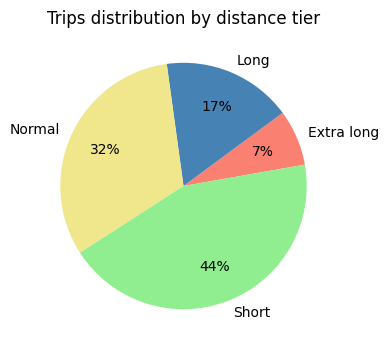

In [70]:
# Plot pie chart for trip categories
plt.figure(figsize=(8,4))
plt.pie(distribution, startangle=10, colors=['salmon', 'steelblue', 'khaki', 'lightgreen'], labels=distribution.index,
    autopct=lambda p: f"{p:.0f}%",
    pctdistance=0.7)
plt.title('Trips distribution by distance tier')
plt.show()

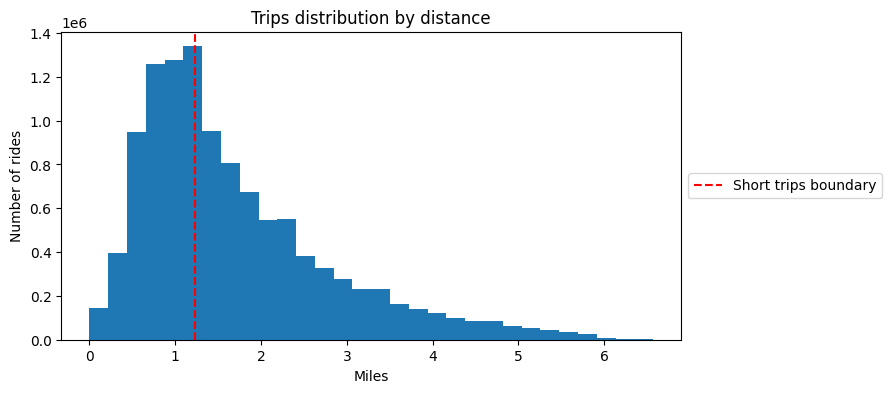

In [79]:
plt.figure(figsize=(8,4))
plt.hist(df['trip_distance'], bins=30)
plt.xlabel('Miles')
plt.ylabel('Number of rides')
plt.title('Trips distribution by distance')
plt.axvline(boundary, color='red', linestyle='--', label='Short trips boundary')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [84]:
# Analyze financial statistics for short trips
analyze_short_trip_economics(boundary)

   1
0  1
